# Time Series Analysis and Forecasting

This is a series of notebooks to support lectures on _Time series analysis and forecast_.

![](https://user-images.githubusercontent.com/49638680/154160268-cf39a1ec-3557-4940-8853-d06fc7a79acf.png)

## Time series Forecast and Classification

In paticular, over this notebook we are going to use a Transformer model in order to implement a time series forecast.

### Some references

1. [Transformer Architecture](https://arxiv.org/abs/1706.03762)
2. [Adversarial Sparse Transformer for Time Series Forecasting](https://proceedings.neurips.cc/paper/2020/file/c6b8c8d762da15fa8dbbdfb6baf9e260-Paper.pdf)
3. [Deep Transformer Models for Time Series Forecasting: The Influenza Prevalence Case](https://arxiv.org/abs/2001.08317)
4. [The Time Series Transformer](https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3)
5. [Transformers for Time-series Forecasting](https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820)
6. [Darts](https://pythonrepo.com/repo/unit8co-darts-python-machine-learning)

# DARTS

Darts is a great library for easy manipulation and forecasting of time series. It contains a variety of models, from classics such as ARIMA to deep neural networks. 

The main strength of such a library is that it is easy to use and you can change model by a simple line of code.

You can see this notebook as a bonus lecture/tutorial for the use of darts for time series forecasting.


# Time series with attention models

For these kinds of tasks, a pretty straightforward procedure would be to use an autoregressive model of some kind (like *ARIMA*, *ARMAX*); these models allow us to take into account autocorrelations in a time series, and also can accept the deterministic features in the future (typically called “exogenous variables”). One limitation of ARMAX is that it is a linear model, and also one needs to specify the order of autocorrelations to be taken into account parametrically. 
Attention models, instead, can learn nonlinear patterns, and are able to take into account autocorrelations in a nonparametric way, focusing on the most important contributions.

Furthermore, Attention model allows us to take into account longer sequences avoind the information bottleneck problem and focusing on the most relevant part of the past in order to forecast the future behaviour of the time series.

In [14]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import shutil
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler

from darts import TimeSeries
from darts.models import TransformerModel, ExponentialSmoothing
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from darts.datasets import (
    AirPassengersDataset, 
    SunspotsDataset, 
    MonthlyMilkDataset, 
    MonthlyMilkIncompleteDataset ,
)

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sns.set()

# Importing data and building dataset

In this notebook, we will demonstrate how to perform some common preprocessing tasks using darts

As a toy example, we will use the [Monthly Milk Production dataset](https://www.kaggle.com/tejasgosavi/monthlymilkproductionpounds).

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample


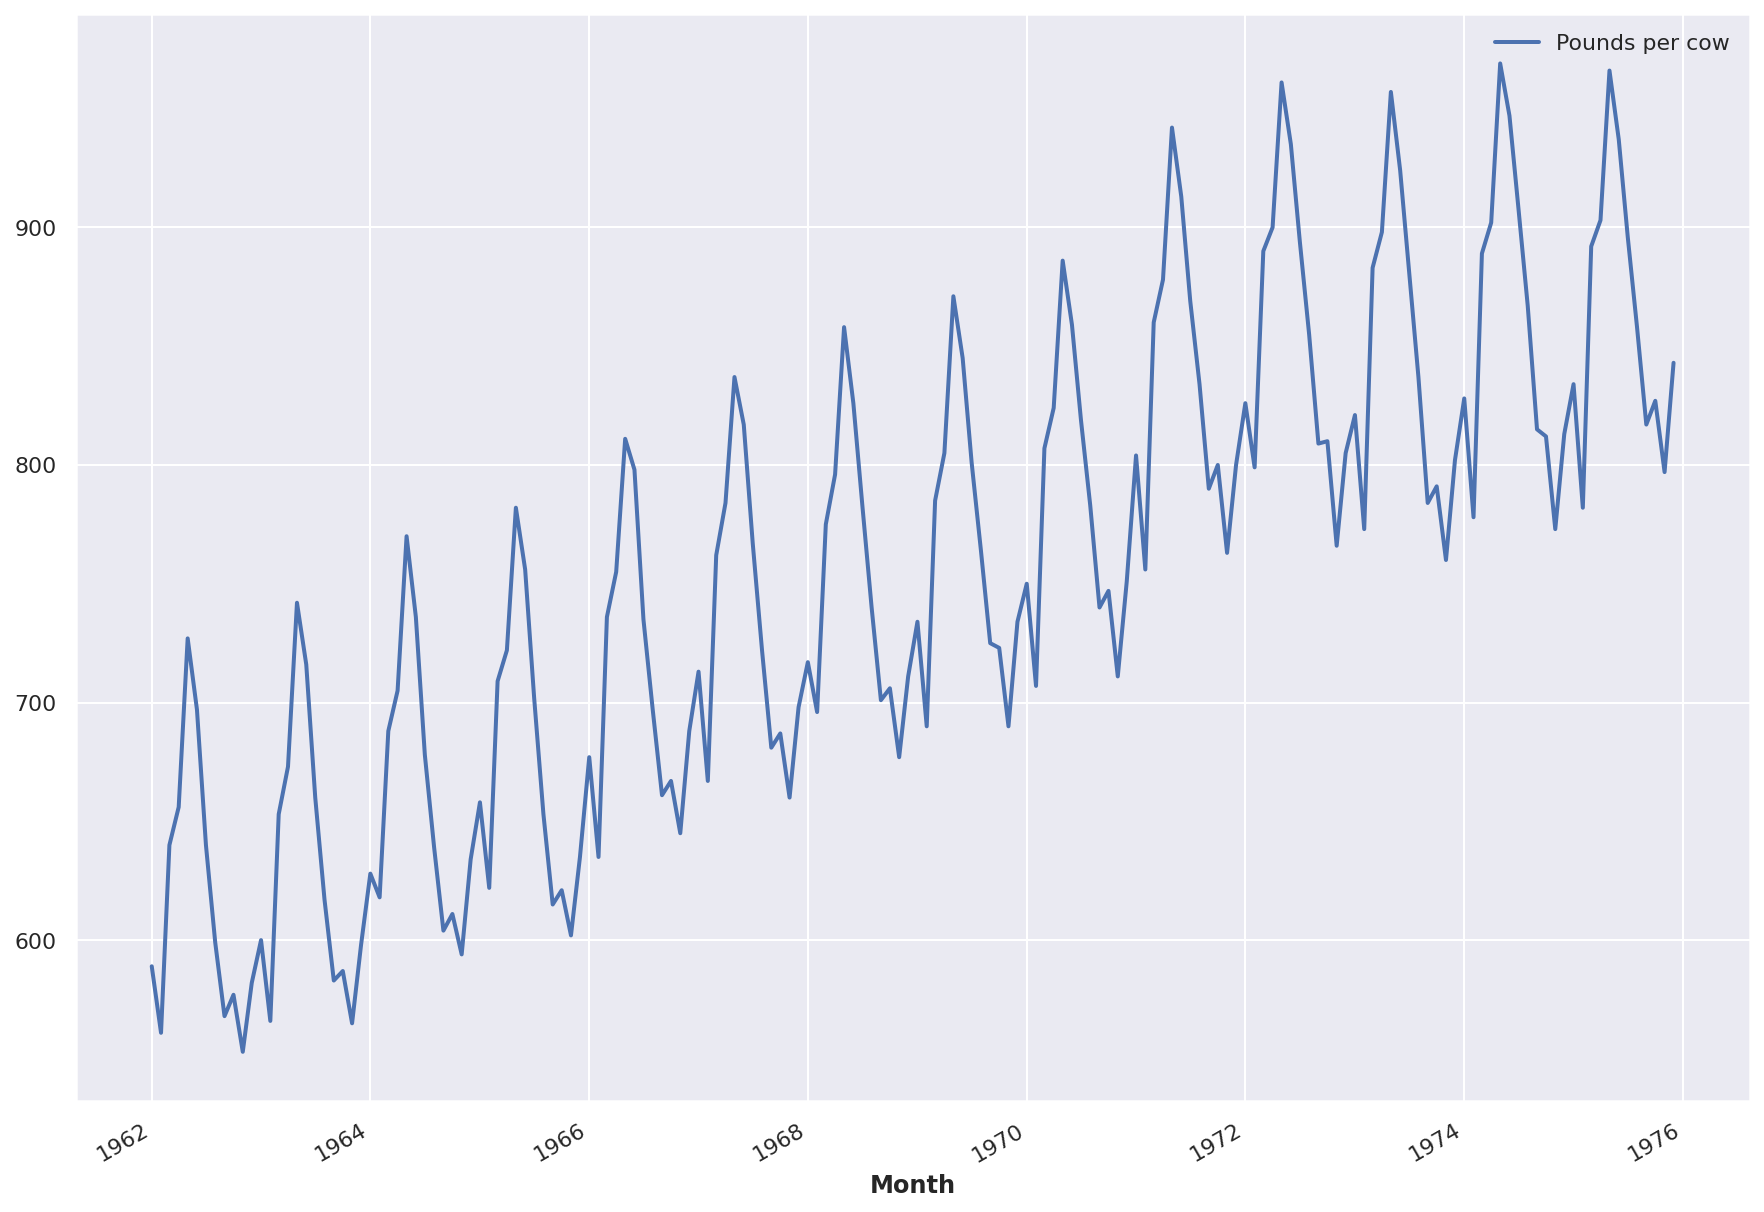

In [6]:
series = MonthlyMilkDataset().load()

print(series)
series.plot();

#### Goal
> Forecast the time series future behaviour given the training data. 

#### Rescaling a time series using darts Scaler.
Some applications may require your datapoints to be between $0$ and $1$ (e.g. to feed a time series to a Neural Network based forecasting model). This is easily achieved using the default `Scaler`, which is a wrapper around sklearn.`preprocessing.MinMaxScaler(feature_range=(0, 1))`.


In [7]:
scaler = Scaler()
rescaled = scaler.fit_transform(series)
print(rescaled)

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[0.08653846]],

       [[0.01923077]],

       [[0.20913462]],

       [[0.24759615]],

       [[0.41826923]],

       [[0.34615385]],

       [[0.20913462]],

       [[0.11057692]],

       [[0.03605769]],

       [[0.05769231]],

...

       [[0.81490385]],

       [[0.84134615]],

       [[0.99278846]],

       [[0.92307692]],

       [[0.82451923]],

       [[0.73317308]],

       [[0.63461538]],

       [[0.65865385]],

       [[0.58653846]],

       [[0.69711538]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample


As per usual, you can retrieve the original series by calling `inverse_transform()`.

Note that the `Scaler` also allows to specify other scalers in its constructor, as long as they implement `fit()`, `transform()` and `inverse_transform()` methods on `TimeSeries` (typically scalers from scikit-learn).

You can read further on [darts documentation](https://unit8co.github.io/darts/examples/).

### More complex (and useful) transformations

As last preprocessing step, let's explore some nicer transformation. In the Monthly Milk Production dataset used earlier, some of the difference between the months comes from the fact that some months contain more days than others, resulting in a larger production of milk during those months. This makes the time series more complex, and thus harder to predict.

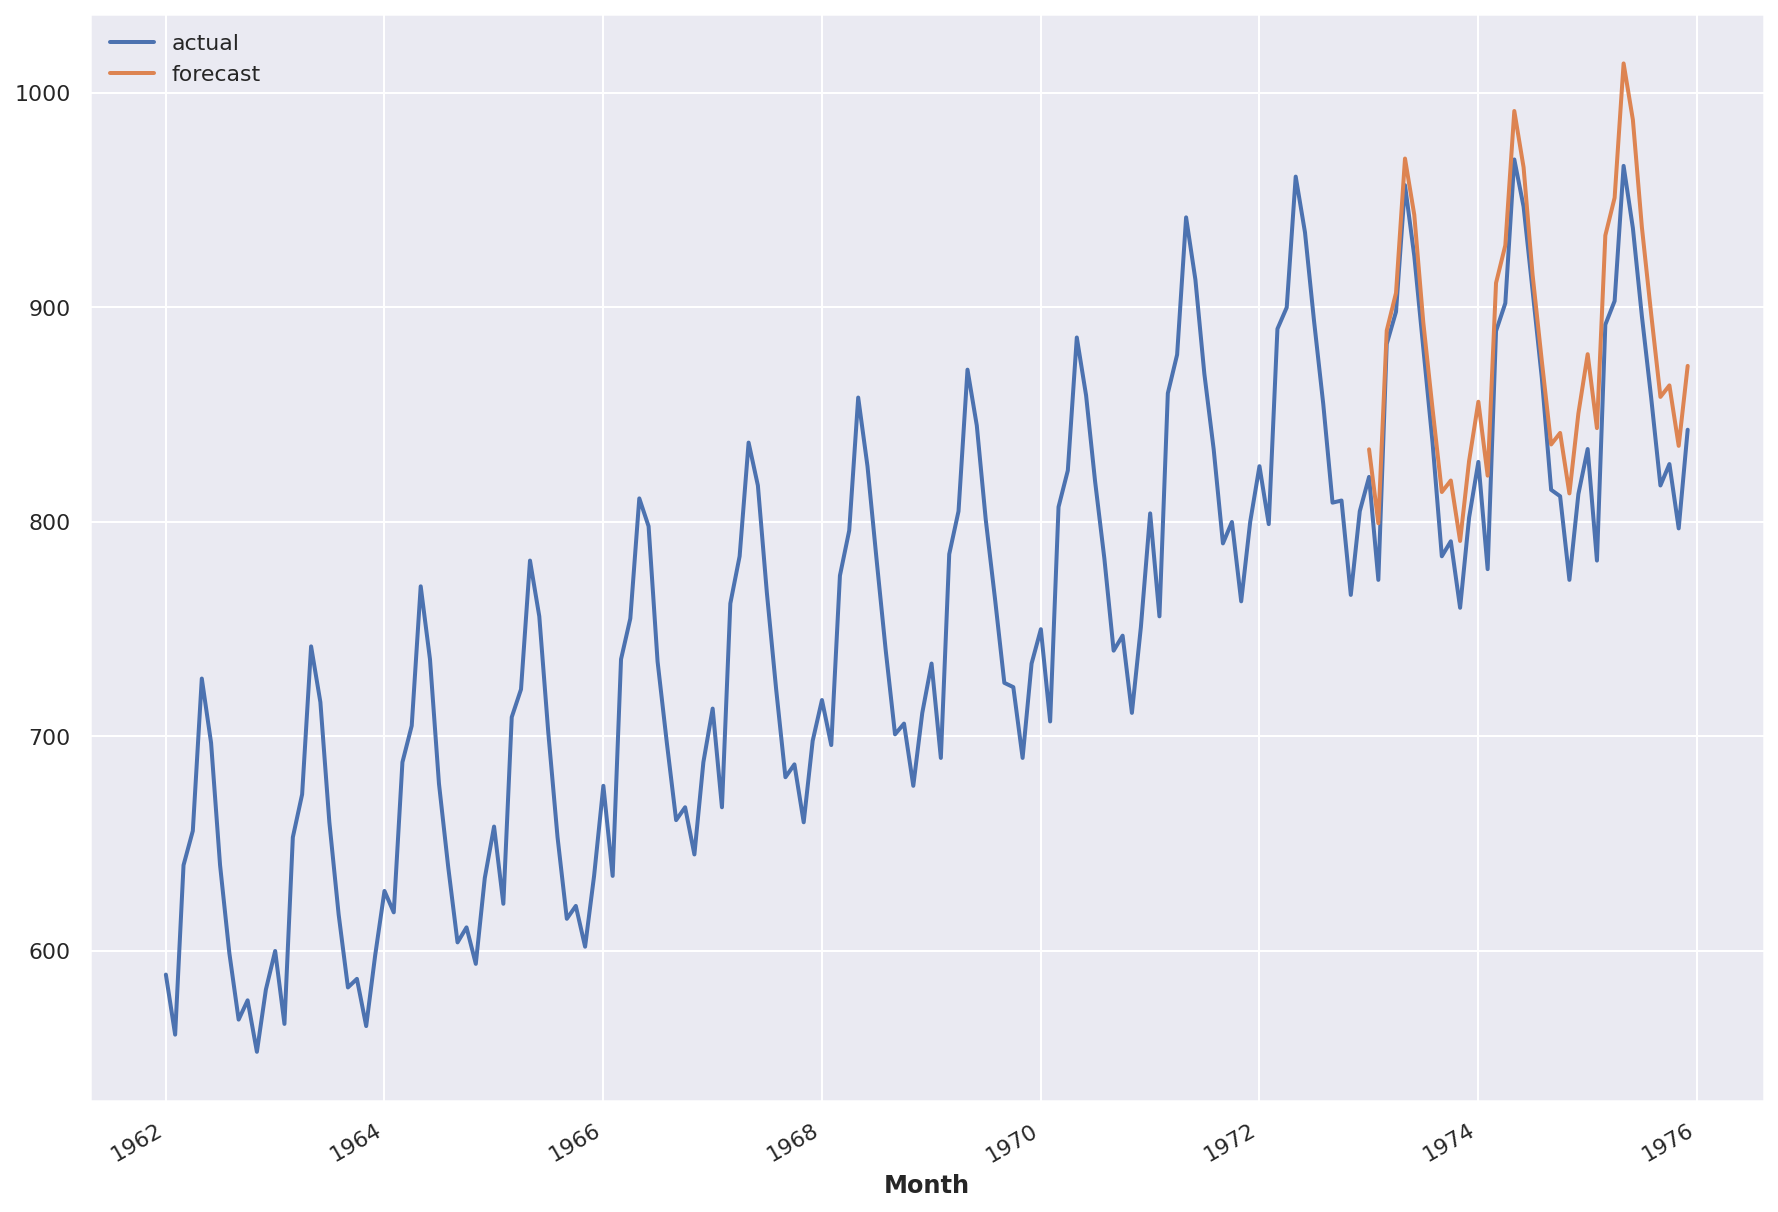

In [9]:
training, validation = series.split_before(pd.Timestamp("1973-01-01"))

model = ExponentialSmoothing()
model.fit(training)
forecast = model.predict(36)

plt.title("MAPE = {:.2f}%".format(mape(forecast, validation)))
series.plot(label="actual")
forecast.plot(label="forecast")
plt.legend();

To take this fact into account and achieve better performance, we could instead:

1. Transform the time series to represent the average daily production of milk for each month (instead of the total production per month);

2. Make a forecast;

3. Inverse the transformation;

Let’s see how this would be implemented using `InvertibleMapper` and `pd.timestamp.days_in_month`

(Idea taken from [“Forecasting: principles and Practice”](https://otexts.com/fpp2/transformations.html) by Hyndman and Athanasopoulos)

To transform the time series, we have to divide a monthly value (the data point) by the number of days in the month given by the value’s corresponding timestamp.

`map()` (and thus `Mapper` / `InvertibleMapper`) makes this convenient by allowing to apply a transformation function which uses both the value and its timestamp to compute the new value: 
```python
f(timestamp, value) = new_value
```

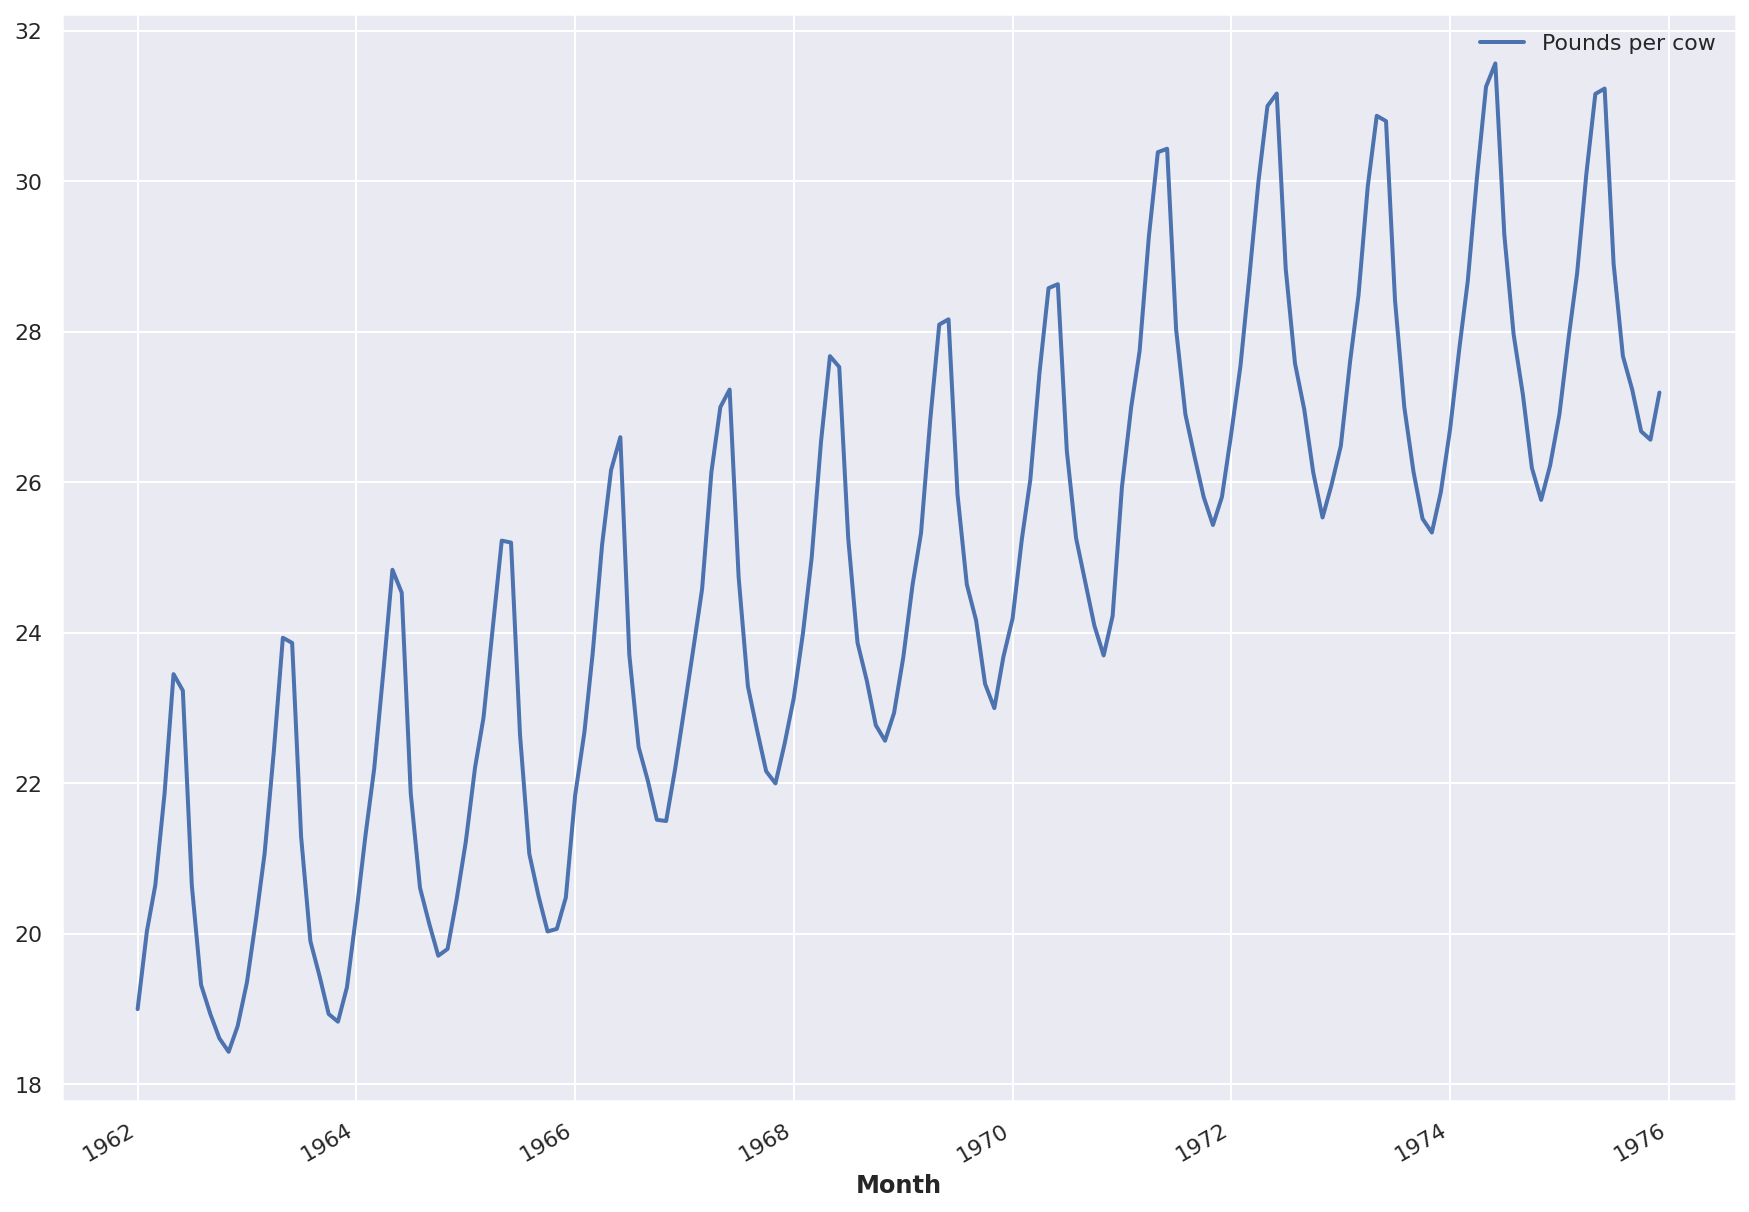

In [10]:
# Transform the time series
toDailyAverage = InvertibleMapper(
    fn=lambda timestamp, x: x / timestamp.days_in_month,
    inverse_fn=lambda timestamp, x: x * timestamp.days_in_month,
)

dailyAverage = toDailyAverage.transform(series)

dailyAverage.plot();

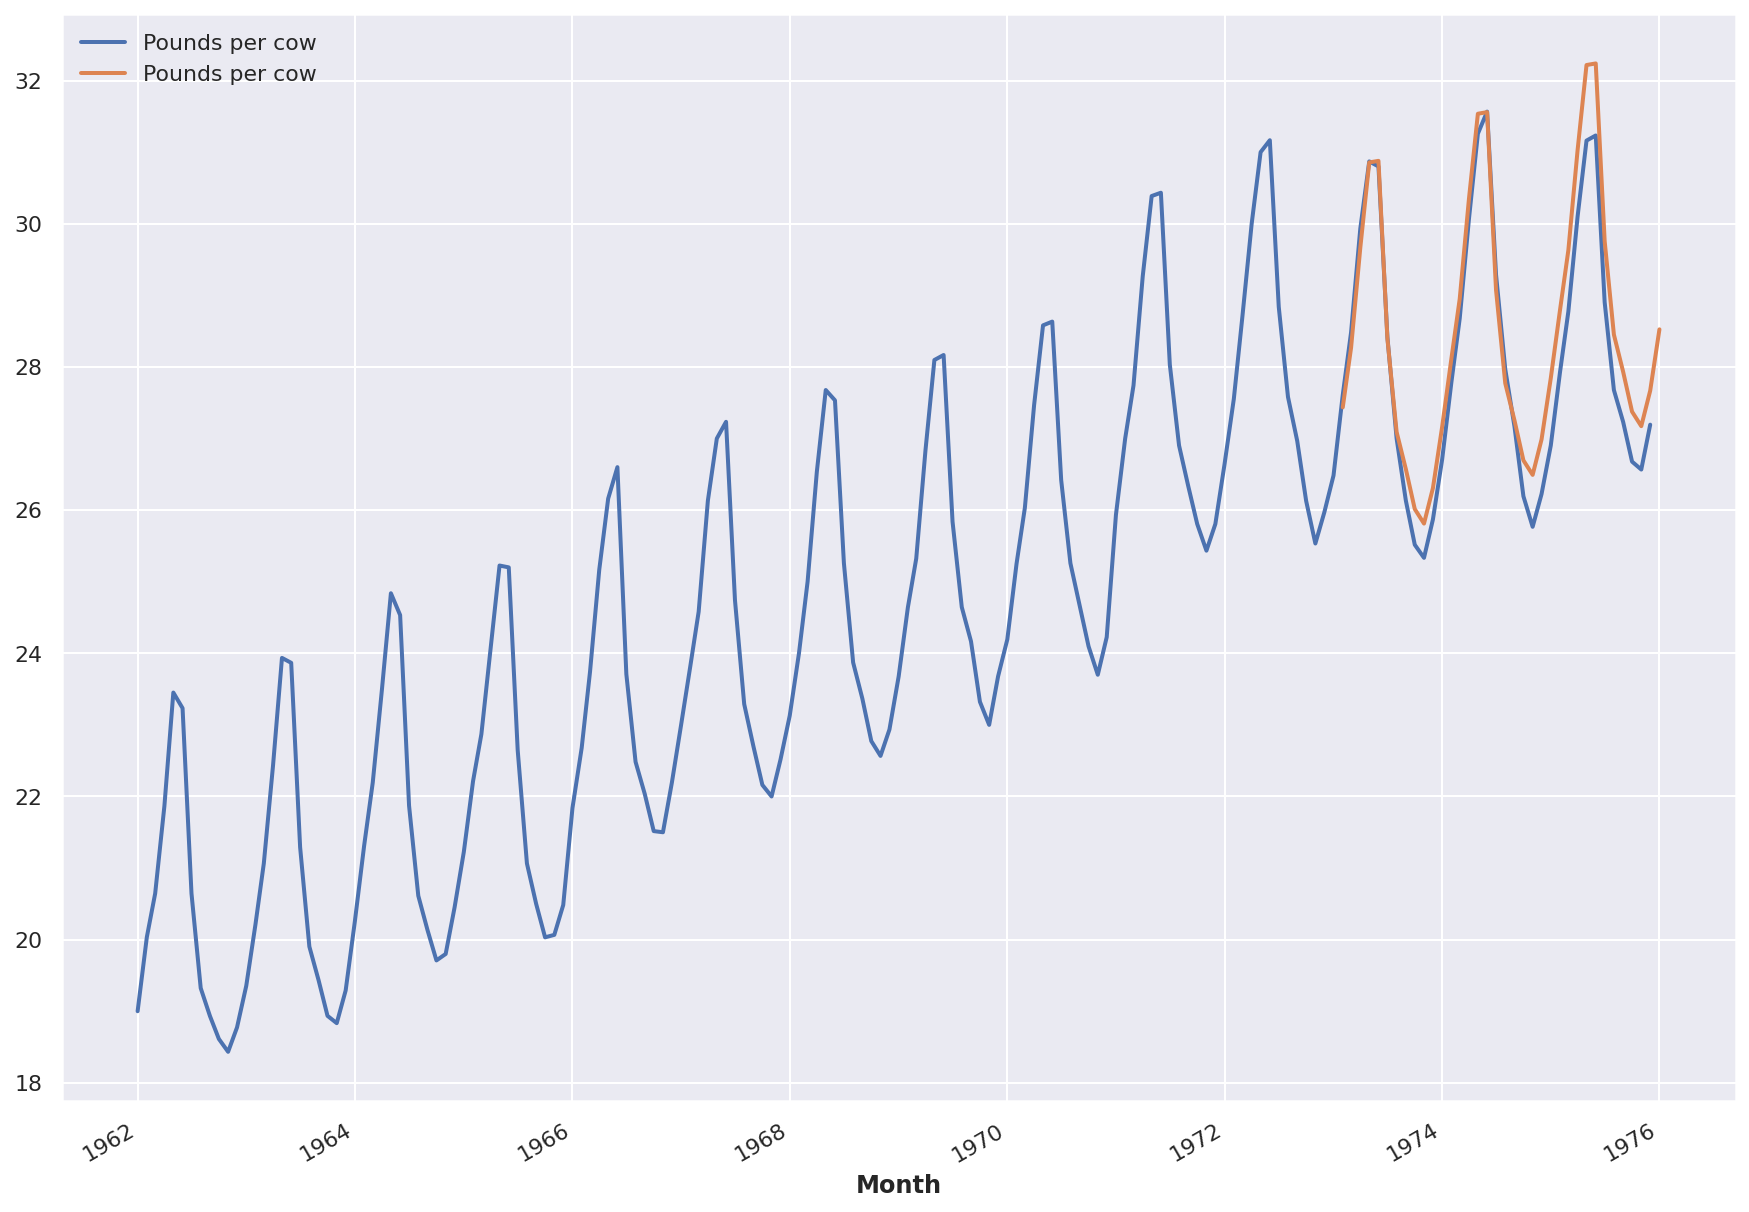

In [11]:
# Make a forecast
dailyavg_train, dailyavg_val = dailyAverage.split_after(pd.Timestamp("1973-01-01"))

model = ExponentialSmoothing()
model.fit(dailyavg_train)
dailyavg_forecast = model.predict(36)

plt.title("MAPE = {:.2f}%".format(mape(dailyavg_forecast, dailyavg_val)))
dailyAverage.plot()
dailyavg_forecast.plot()
plt.legend();

In [12]:
# Inverse the transformation
# Here the forecast is stochastic; so we take the median value
forecast = toDailyAverage.inverse_transform(dailyavg_forecast)

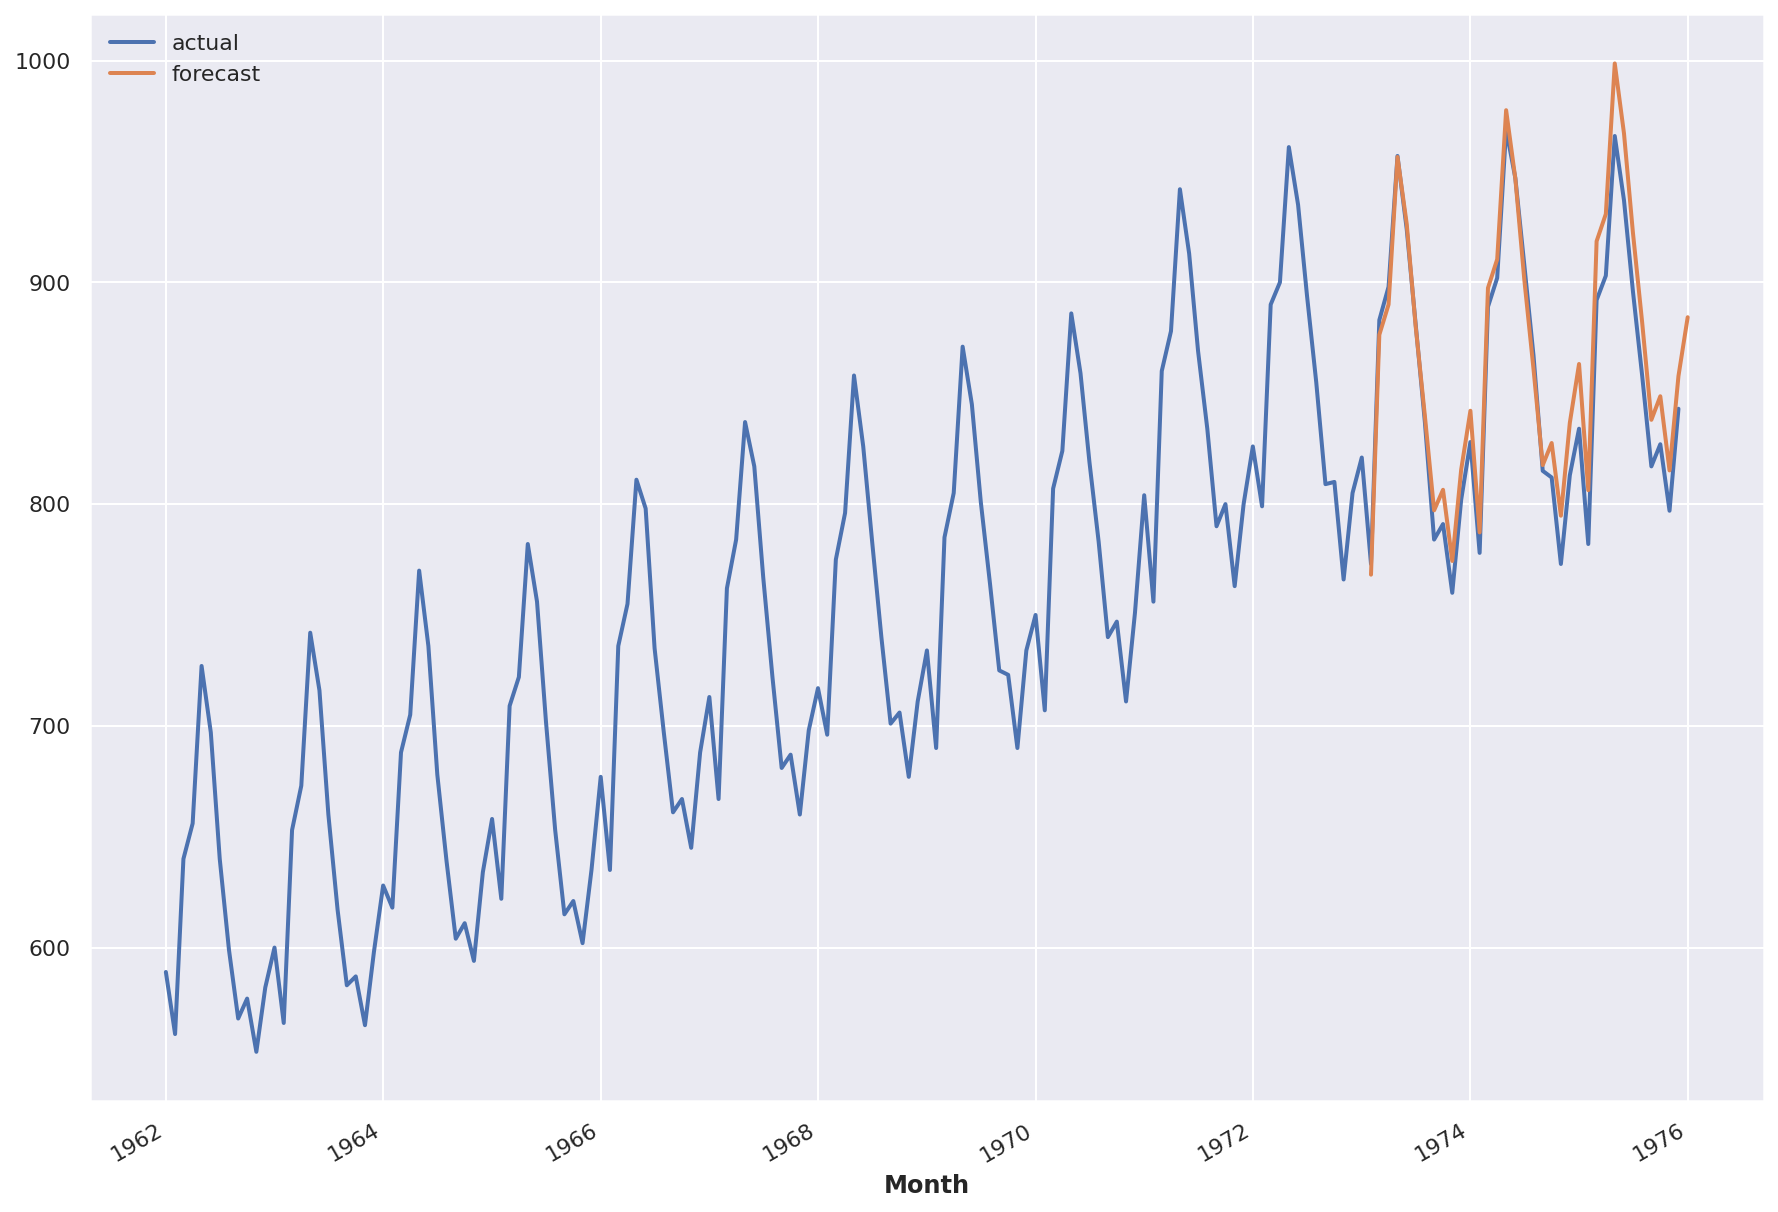

In [13]:
plt.title("MAPE = {:.2f}%".format(mape(forecast, validation)))
series.plot(label="actual")
forecast.plot(label="forecast")
plt.legend();

## Transformer model

### Air Passengers Example
First, we will test the performance of the transformer architecture on the ‘air passengers’ dataset.

In [15]:
# Read data:
series = AirPassengersDataset().load().astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

In [17]:
print(f"the 'air passengers' dataset has {len(series)} data points")

the 'air passengers' dataset has 144 data points


#### Some comments

We train a standard transformer architecture with default hyperparameters, tweaking only two of them:

* `d_model`, the input dimensionality of the transformer architecture (after performing time series embedding). Its default value is $512$. We lower the value from $512$ to $64$, since it is hard to learn such an high-dimensional representation from an univariate time series

* `nhead`, the number of heads in the multi-head attention mechanism. We increase the value from $8$ to $32$. This means that we compute multi-head attention with $32$ heads of size `d_model`/`nhead`= $\tfrac{64}{32}=2$ each. This way, we obtain low-dimensional heads that are hopefully suitable to learn from univariate time series

The goal is to perform one-step forecasting.

In [18]:
my_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

In [19]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True);

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Forecast
Let’s look at the predictions on the validation set.

First, by using the “current” model - i.e., the model at the end of the training procedure:

Predicting: 4it [00:00, ?it/s]

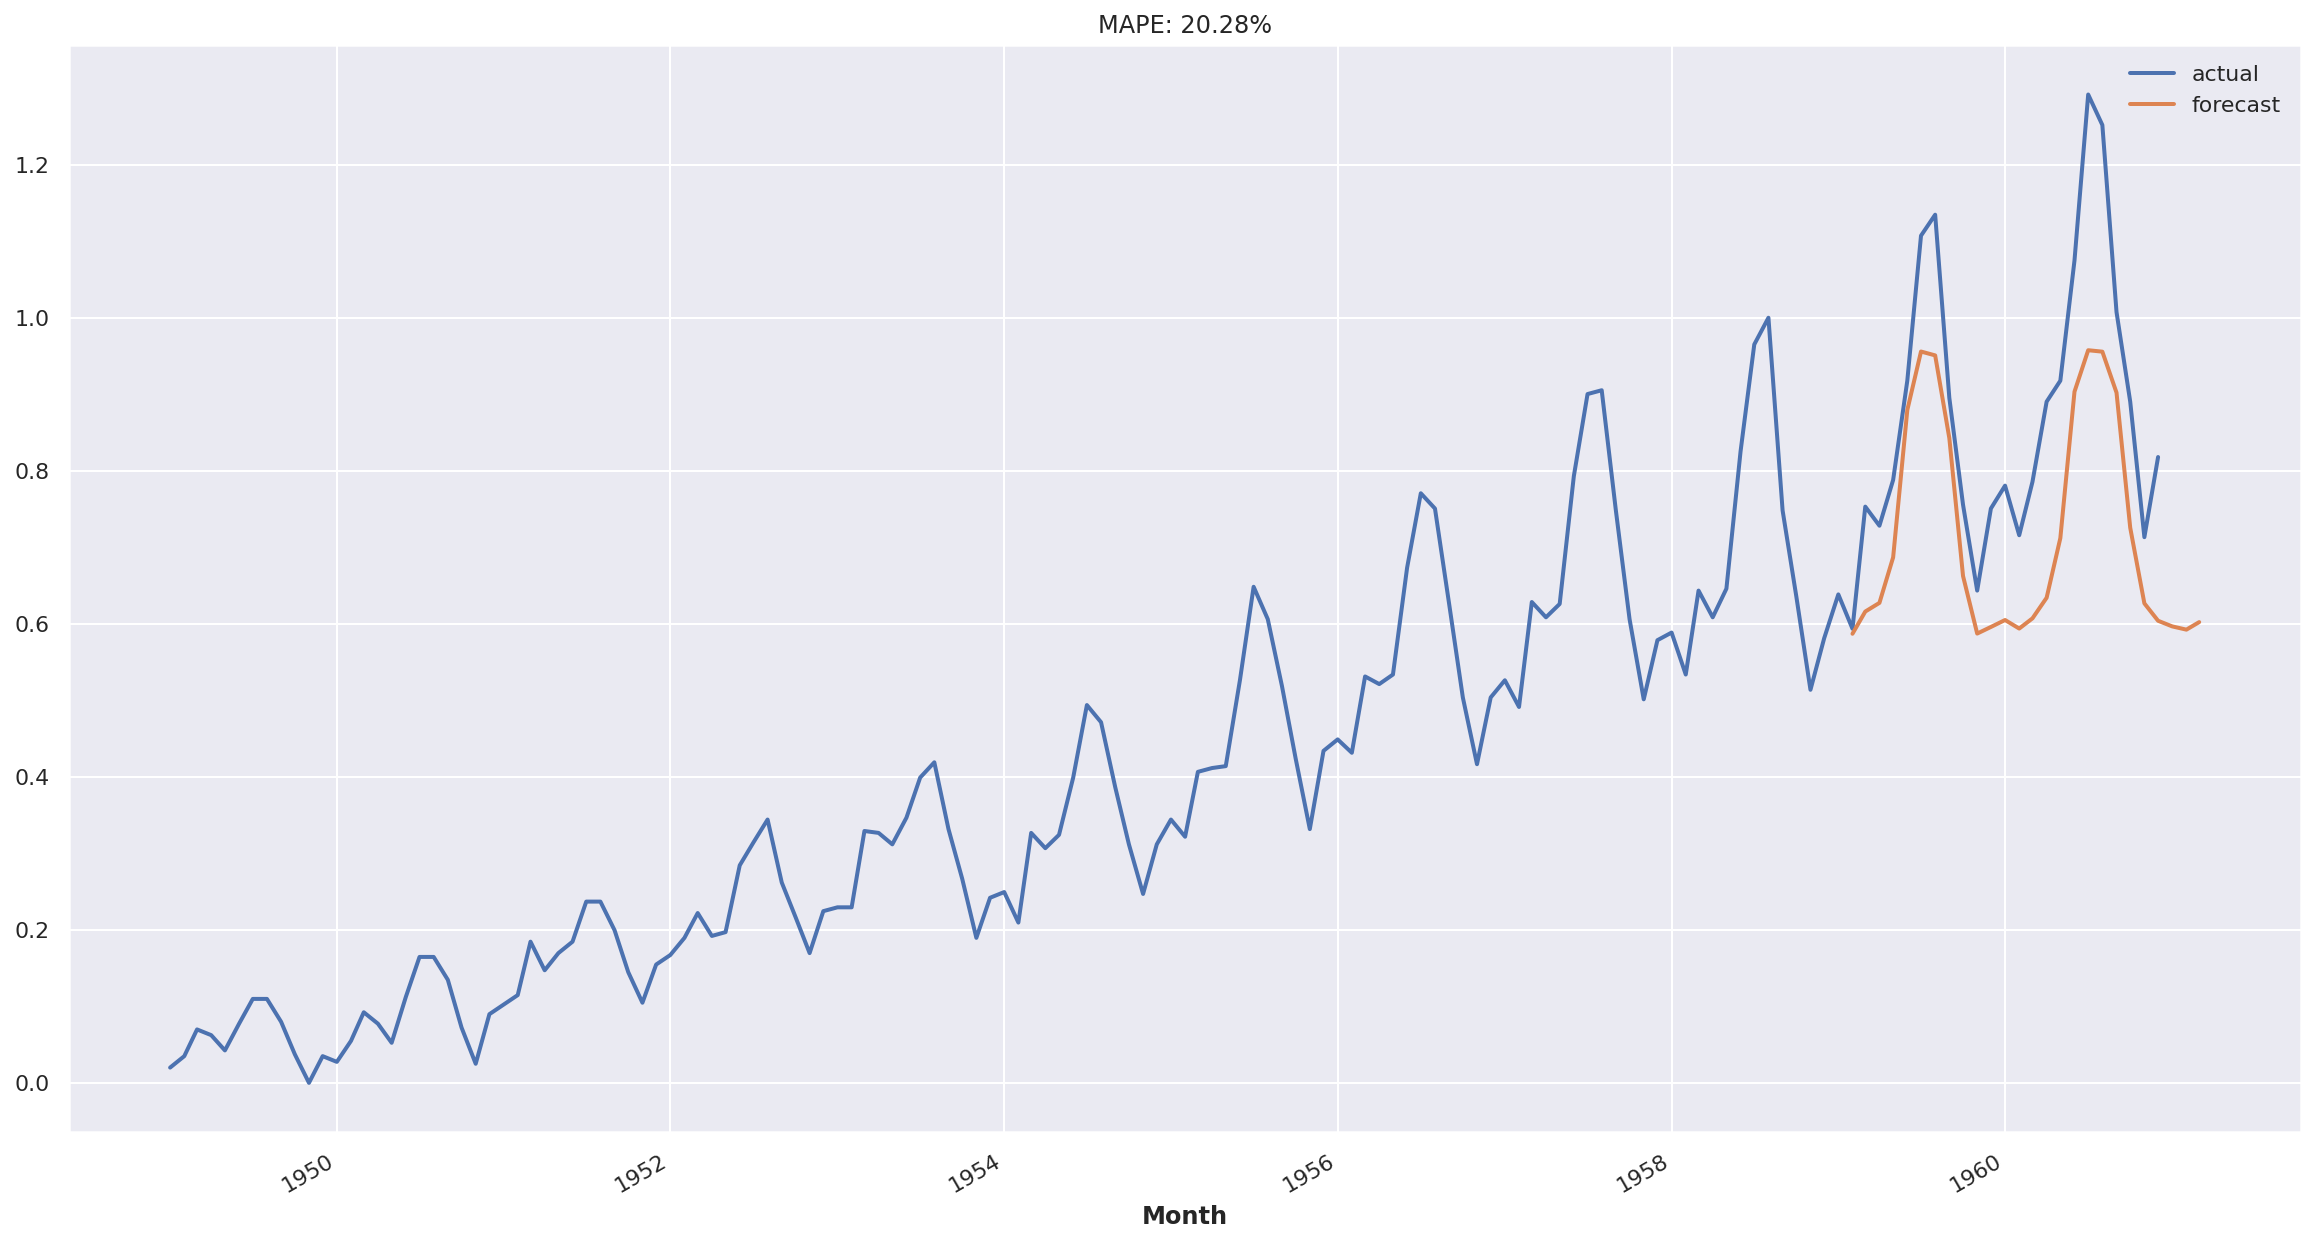

In [21]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(20, 10))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()


eval_model(my_model, 26, series_scaled, val_scaled)

Then, by using the best model obtained over training, according to validation loss:

Predicting: 0it [00:00, ?it/s]

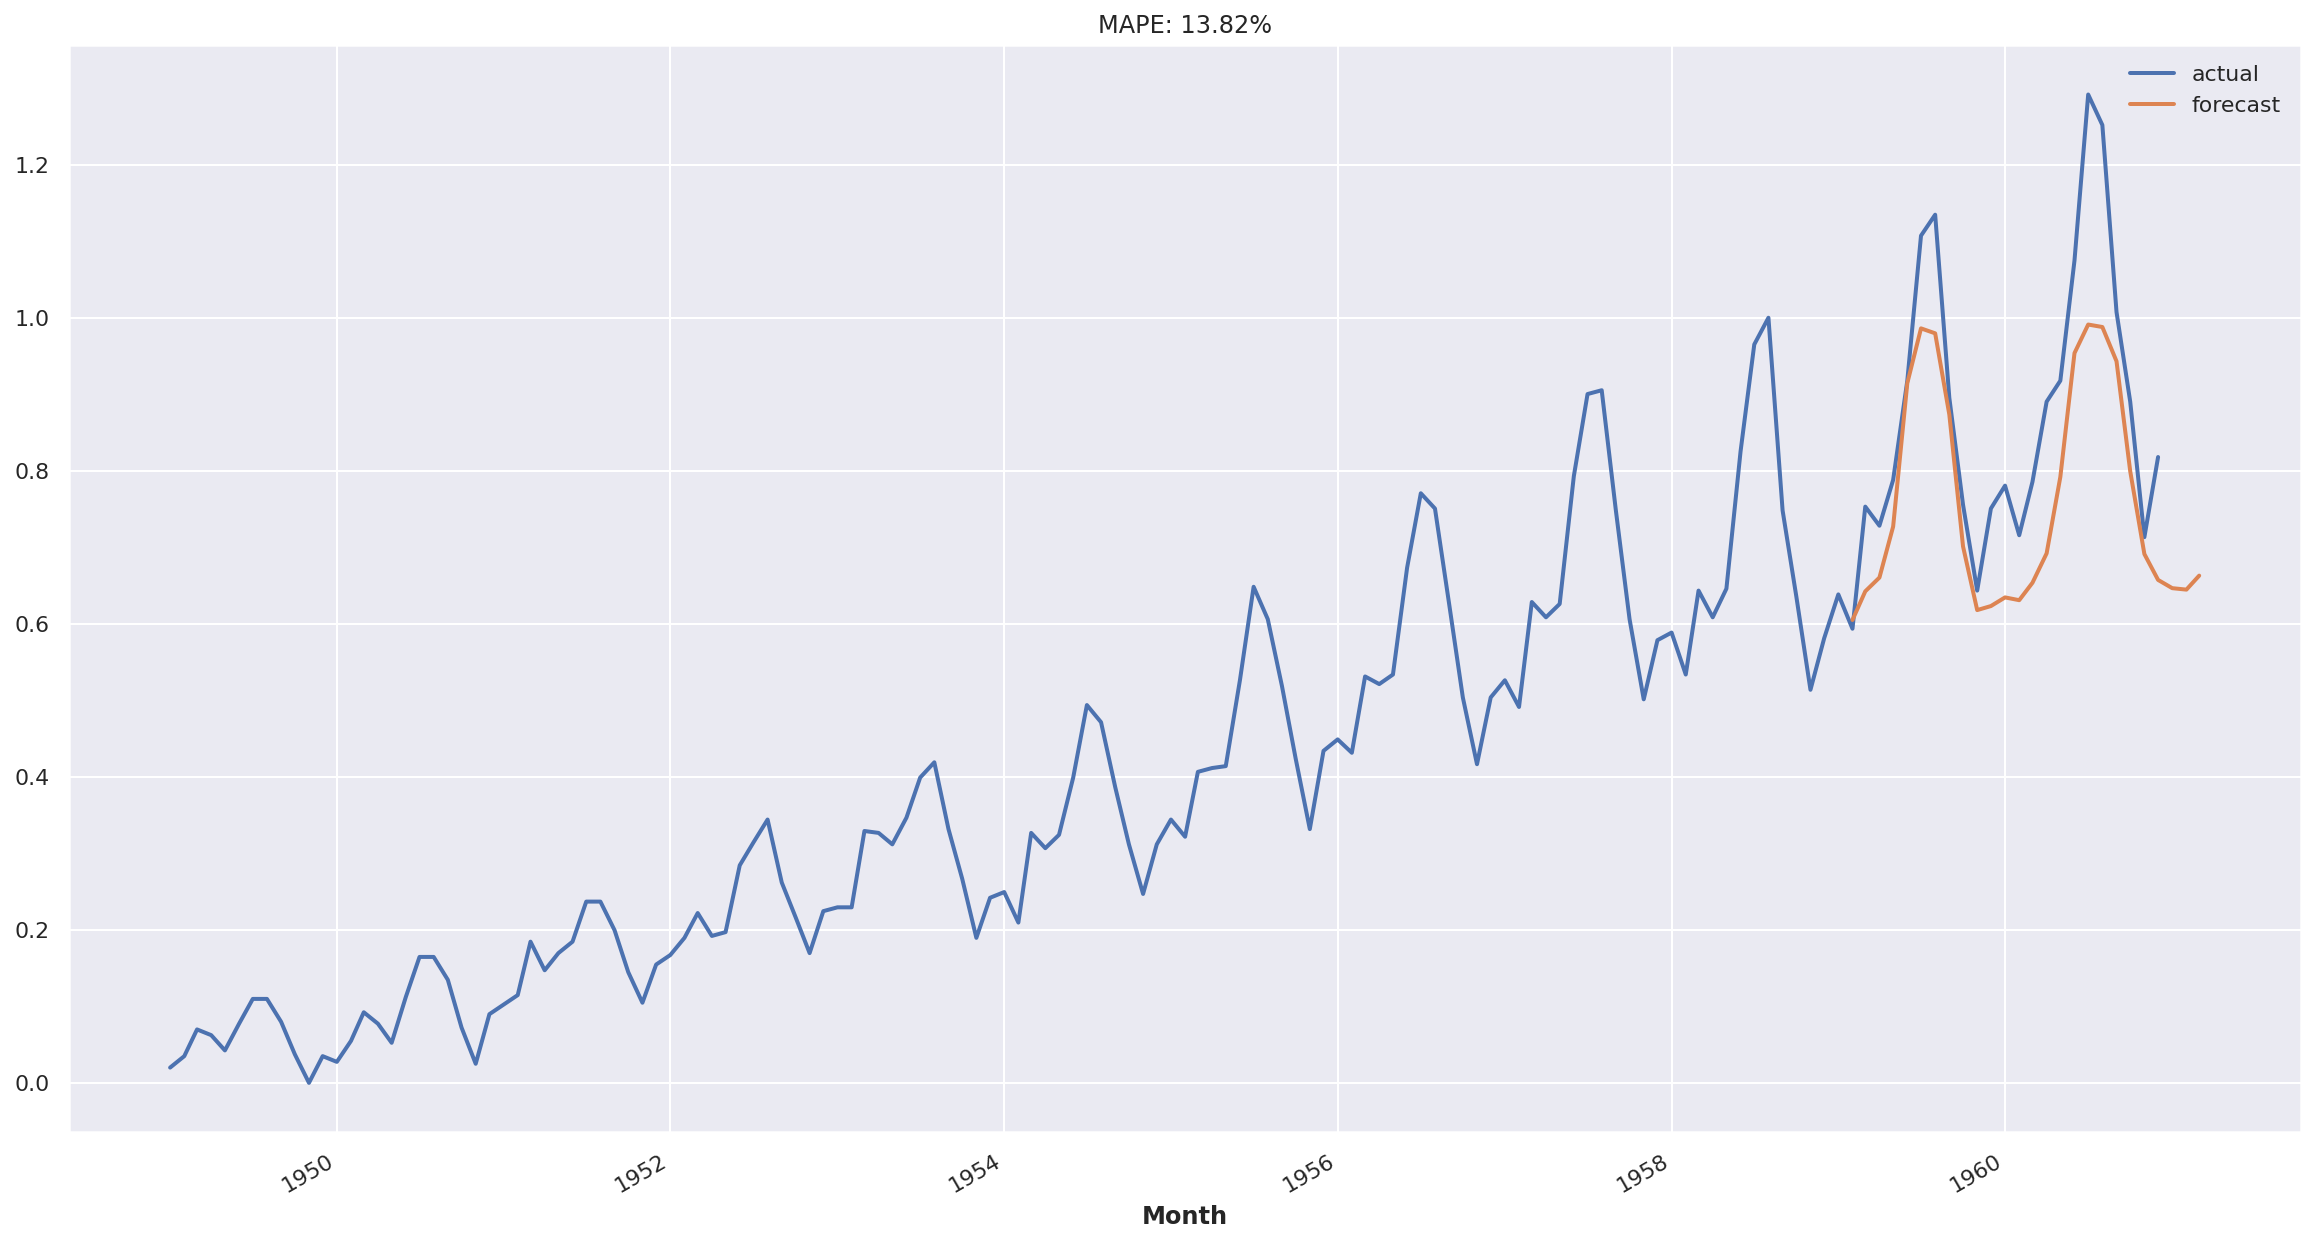

In [22]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="air_transformer", best=True
)
eval_model(best_model, 26, series_scaled, val_scaled)

Let’s backtest our Transformer model to evaluates its performance at a forecast horizon of $6$ months:

  0%|          | 0/19 [00:00<?, ?it/s]

Predicting: 4it [00:00, ?it/s]

  5%|▌         | 1/19 [00:00<00:03,  4.85it/s]

Predicting: 4it [00:00, ?it/s]

 11%|█         | 2/19 [00:00<00:03,  5.25it/s]

Predicting: 4it [00:00, ?it/s]

 16%|█▌        | 3/19 [00:00<00:02,  5.77it/s]

Predicting: 4it [00:00, ?it/s]

 21%|██        | 4/19 [00:00<00:02,  6.37it/s]

Predicting: 4it [00:00, ?it/s]

 26%|██▋       | 5/19 [00:00<00:02,  6.82it/s]

Predicting: 4it [00:00, ?it/s]

 32%|███▏      | 6/19 [00:00<00:01,  7.31it/s]

Predicting: 4it [00:00, ?it/s]

 37%|███▋      | 7/19 [00:01<00:01,  7.66it/s]

Predicting: 4it [00:00, ?it/s]

 42%|████▏     | 8/19 [00:01<00:01,  8.24it/s]

Predicting: 4it [00:00, ?it/s]

 47%|████▋     | 9/19 [00:01<00:01,  8.34it/s]

Predicting: 4it [00:00, ?it/s]

 53%|█████▎    | 10/19 [00:01<00:01,  8.53it/s]

Predicting: 4it [00:00, ?it/s]

 58%|█████▊    | 11/19 [00:01<00:00,  8.52it/s]

Predicting: 4it [00:00, ?it/s]

 63%|██████▎   | 12/19 [00:01<00:00,  8.72it/s]

Predicting: 4it [00:00, ?it/s]

 68%|██████▊   | 13/19 [00:01<00:00,  8.85it/s]

Predicting: 4it [00:00, ?it/s]

 74%|███████▎  | 14/19 [00:01<00:00,  8.96it/s]

Predicting: 4it [00:00, ?it/s]

 79%|███████▉  | 15/19 [00:01<00:00,  8.92it/s]

Predicting: 4it [00:00, ?it/s]

 84%|████████▍ | 16/19 [00:02<00:00,  9.05it/s]

Predicting: 4it [00:00, ?it/s]

 89%|████████▉ | 17/19 [00:02<00:00,  9.22it/s]

Predicting: 4it [00:00, ?it/s]

 95%|█████████▍| 18/19 [00:02<00:00,  8.96it/s]

Predicting: 4it [00:00, ?it/s]

100%|██████████| 19/19 [00:02<00:00,  8.03it/s]


MAPE: 11.22%


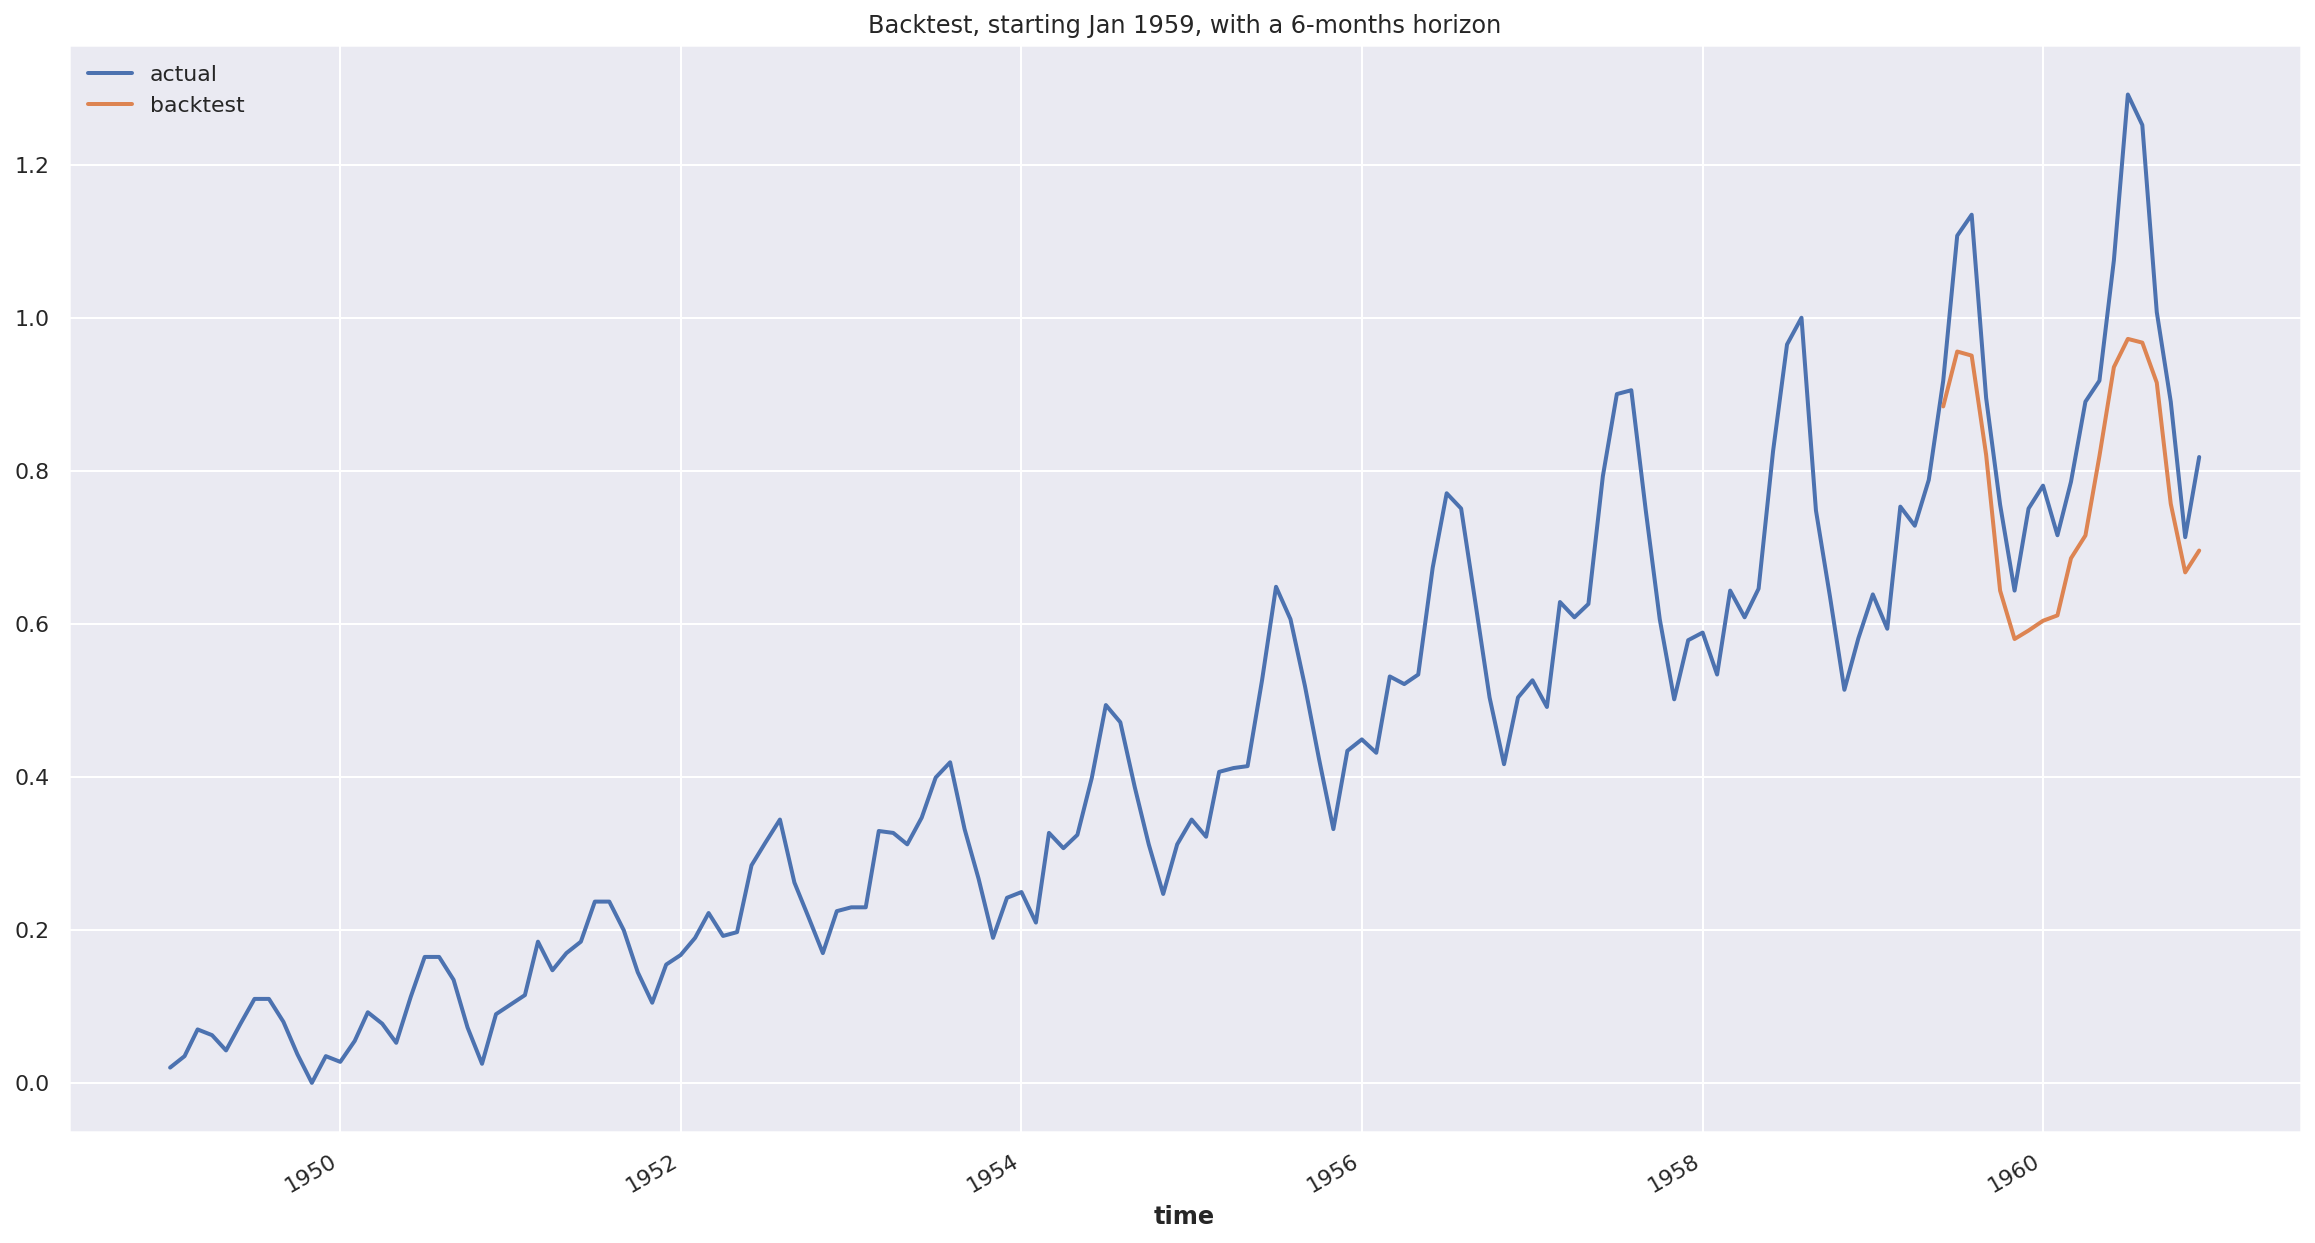

In [23]:
backtest_series = my_model.historical_forecasts(
    series=series_scaled,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

plt.figure(figsize=(20, 10))
series_scaled.plot(label="actual", lw=2)
backtest_series.plot(label="backtest", lw=2)
plt.legend()
plt.title("Backtest, starting Jan 1959, with a 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            scaler.inverse_transform(series_scaled),
            scaler.inverse_transform(backtest_series),
        )
    )
)

## Some observations

It was very simple to build and train a transformer model for time series forecasting. However we have lost control over the process. Be sure to understand what is going on before using such great tools like darts.

---

## Exercises 

1. Perform hyperparameter finetuning (you can use  a tool like the holy spirit, grid search or a framework like [optuna](https://optuna.org) if you like).

2. Use darts on the [Washington bike sharing dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) and compare results with the model we developed in lectures.

3. Use darts on `SunspotsDataset` (already imported) and try to analyse the results.

---

# Conclusion

The final model shows very good results on the data-set, this would outperform an implementation based on LSTM, which would suffer from short-term memory. Moreover, the architecture allows for much more rapid training, as the computations during training are done concurrently rather than sequentially. 

It can be concluded that the Transformer architecture, which is traditionally applied to NLP problems, has large potential in time series forecasting.